This is the first notebook looking at UEP results. Code is primarily copied from `output_investigation_08.ipynb`.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import pickle
from scipy import stats

In [2]:
from generate_opt_objects import A_b_generation

**PNC:/Users/mikestanley/anaconda3/envs/mc_sampling/lib/python3.8/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  pyproj could not be found, so IO/API coordinates cannot be converted to lat/lon; to fix, install pyproj or basemap (e.g., `pip install pyproj)`


In [20]:
# results base directory
BASE_DIR = './data/carbon_flux/results'

# save filepath
SAVE_FIG_BASE = '../figures/interval_optimizations/continental_US_jun2010/dual/09'

In [4]:
# paths
OBS_FP = '../fixed_optimization_inputs/y_affine_corrected.npy'

In [5]:
# get necessary objects
with open(OBS_FP, 'rb') as f:
    y_obs = np.load(f)
    
# gosat data
with open('../fixed_optimization_inputs/gosat_df_jan1_aug31_2010.csv', 'rb') as f:
    gosat_df = pd.read_csv(f)
L_inv_vec = 1 / gosat_df.xco2_unc.values
    
# tranform the data
y_tilde = np.multiply(L_inv_vec, y_obs)

CONSTR_DIR = '/Users/mikestanley/Research/Carbon_Flux/optimization/data/sign_corrected'
A, b = A_b_generation(
    box_constraint_fp=CONSTR_DIR + '/scipy_bnds.pkl'
)

FUNC_FP = '/Users/mikestanley/Research/Carbon_Flux/optimization'
FUNC_FP += '/src_admm/data/carbon_flux/objects/na_june_functional.npy'
with open(FUNC_FP, 'rb') as f:
    h = np.load(f)

In [6]:
# psi_alpha
with open('./data/carbon_flux/objects/opt_res_cont.pkl', 'rb') as f:
    opt_slack = pickle.load(f)
    
PSI_ALPHA = np.sqrt(stats.chi2.ppf(q=.95, df=1) + opt_slack[1])

In [7]:
def f_w(w, y=y_tilde, psi_alpha=PSI_ALPHA, b=b, c=np.zeros_like(b)):
    """ Lower endpoint functional """
    return np.dot(w, y) - psi_alpha * np.linalg.norm(w) - np.dot(b, c)

def f_w_uep(w, y=y_tilde, psi_alpha=PSI_ALPHA, b=b, c=np.zeros_like(b)):
    """ Lower endpoint functional """
    return -np.dot(w, y) + psi_alpha * np.linalg.norm(w) + np.dot(b, c)

# Plotting Functions

In [8]:
def global_avg_plot(w_ser, title_str=None, figsize=(8, 5)):
    """
    Globally averaged weights at daily, weekly, and month res
    
    Parameters
    ----------
        w_ser (pandas series) : weights indexed by time
    """
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize)
    ts_day = w_ser.resample('D').mean()
    ts_week = w_ser.resample('W').mean()
    ts_month = w_ser.resample('M').mean()
    ts_day.plot(ax=ax, label='Day')
    ts_week.plot(ax=ax, label='Week')
    ts_month.plot(ax=ax, label='Month')
    ax.axhline(0, linestyle='--', color='gray')
    ax.legend()
    ax.set_title(title_str)
    plt.show()
    
def month_map_plot(df, w_col_str, norm, vmin=None, vmax=None, figsize=(12, 16), save_fp=None):
    """
    Monthly heat maps for the given weights
    
    Parameters
    ----------
        df        (pandas dataframe)  : contains columns - 'month', 'lon', 'lat', and w_col_str
        w_col_str (str)               : name of w column in df to use
        norm      (mcolors.Normalize) : for color scheme
    """
    # w start
    fig, ax = plt.subplots(ncols=2, nrows=4, figsize=figsize)
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

    for i in range(8):
        row_idx = i // 2
        col_idx = i % 2
        month_idxs = df['month'].astype(int) == i + 1
        sp_i = ax[row_idx, col_idx].scatter(
            df['lon'][month_idxs], df['lat'][month_idxs],
            c=df[w_col_str][month_idxs],
            norm=norm, vmin=vmin, vmax=vmax,
            s=14, cmap='seismic'
        )
        ax[row_idx, col_idx].set_title(months[i])

    plt.colorbar(sp_i,ax=ax[0, 0])
    if save_fp:
        plt.savefig(save_fp, dpi=300)
        plt.close()
    else:
        plt.show()

# Optimization diagnostics

#### Convergence Plots

In [9]:
# read in the raw stdout file
with open(BASE_DIR + '/09/stdout_it0.txt', 'r') as f:
    stdout0_raw = f.readlines()

In [10]:
# isolate the trajectories from the w optimization
all_obj_vals = [float(line[22:34].replace('D', 'e')) for line in stdout0_raw if 'At iterate' in line]
traj_w_01 = all_obj_vals[:]
# traj_c_01 = all_obj_vals[13:16]
# traj_w_02 = all_obj_vals[16:29]
# traj_c_02 = all_obj_vals[29:32]
# traj_w_03 = all_obj_vals[32:45]
# traj_c_03 = all_obj_vals[45:48]
# traj_w_04 = all_obj_vals[48:61]
# traj_c_04 = all_obj_vals[61:64]
# traj_w_05 = all_obj_vals[64:77]
# traj_c_05 = all_obj_vals[77:80]
# traj_w_06 = all_obj_vals[80:93]
# traj_c_06 = all_obj_vals[93:96]
# traj_w_07 = all_obj_vals[96:109]
# traj_c_07 = all_obj_vals[109:112]
# traj_w_08 = all_obj_vals[112:125]
# traj_c_08 = all_obj_vals[125:128]
# traj_w_09 = all_obj_vals[128:141]
# traj_c_09 = all_obj_vals[141:144]
# traj_w_10 = all_obj_vals[144:157]
# traj_c_10 = all_obj_vals[157:]

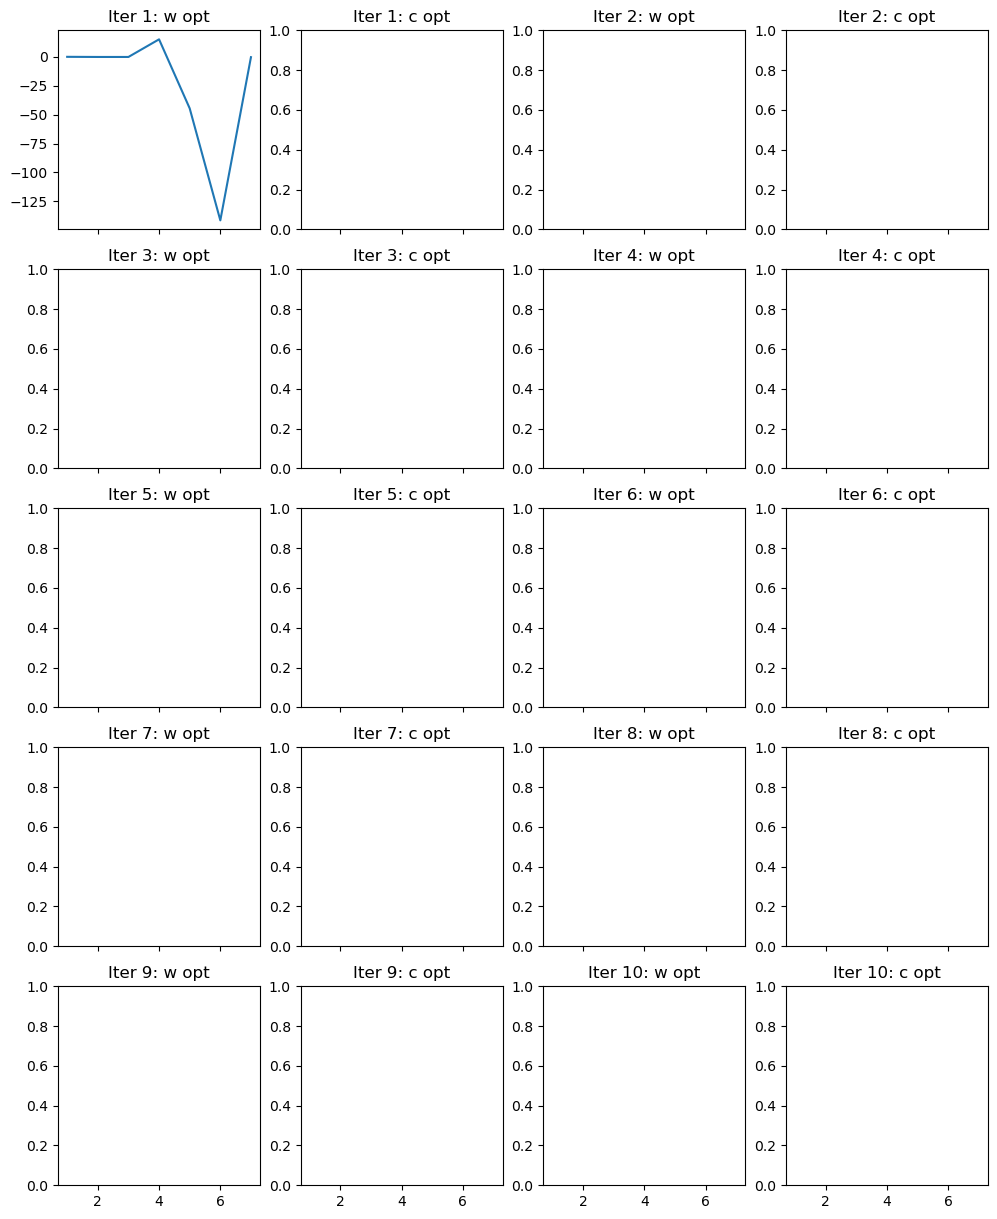

In [11]:
fig, ax = plt.subplots(ncols=4, nrows=5, figsize=(12, 15), sharex=True)

# iteration 1
ax[0, 0].plot(np.arange(1, len(traj_w_01) + 1), traj_w_01)
# ax[0, 1].plot(np.arange(1, len(traj_c_01) + 1), traj_c_01)

# # iteration 2
# ax[0, 2].plot(np.arange(1, len(traj_w_02) + 1), traj_w_02)
# ax[0, 3].plot(np.arange(1, len(traj_c_02) + 1), traj_c_02)

# # # iteration 3
# ax[1, 0].plot(np.arange(1, len(traj_w_03) + 1), traj_w_03)
# ax[1, 1].plot(np.arange(1, len(traj_c_03) + 1), traj_c_03)

# # # iteration 4
# ax[1, 2].plot(np.arange(1, len(traj_w_04) + 1), traj_w_04)
# ax[1, 3].plot(np.arange(1, len(traj_c_04) + 1), traj_c_04)

# # # iteration 5
# ax[2, 0].plot(np.arange(1, len(traj_w_05) + 1), traj_w_05)
# ax[2, 1].plot(np.arange(1, len(traj_c_05) + 1), traj_c_05)

# # # iteration 6
# ax[2, 2].plot(np.arange(1, len(traj_w_06) + 1), traj_w_06)
# ax[2, 3].plot(np.arange(1, len(traj_c_06) + 1), traj_c_06)

# # # iteration 7
# ax[3, 0].plot(np.arange(1, len(traj_w_07) + 1), traj_w_07)
# ax[3, 1].plot(np.arange(1, len(traj_c_07) + 1), traj_c_07)

# # # iteration 8
# ax[3, 2].plot(np.arange(1, len(traj_w_08) + 1), traj_w_08)
# ax[3, 3].plot(np.arange(1, len(traj_c_08) + 1), traj_c_08)

# # # iteration 9
# ax[4, 0].plot(np.arange(1, len(traj_w_09) + 1), traj_w_09)
# ax[4, 1].plot(np.arange(1, len(traj_c_09) + 1), traj_c_09)

# # # iteration 10
# ax[4, 2].plot(np.arange(1, len(traj_w_10) + 1), traj_w_10)
# ax[4, 3].plot(np.arange(1, len(traj_c_10) + 1), traj_c_10)


# labels
ax[0, 0].set_title('Iter 1: w opt')
ax[0, 1].set_title('Iter 1: c opt')
ax[0, 2].set_title('Iter 2: w opt')
ax[0, 3].set_title('Iter 2: c opt')
ax[1, 0].set_title('Iter 3: w opt')
ax[1, 1].set_title('Iter 3: c opt')
ax[1, 2].set_title('Iter 4: w opt')
ax[1, 3].set_title('Iter 4: c opt')
ax[2, 0].set_title('Iter 5: w opt')
ax[2, 1].set_title('Iter 5: c opt')
ax[2, 2].set_title('Iter 6: w opt')
ax[2, 3].set_title('Iter 6: c opt')
ax[3, 0].set_title('Iter 7: w opt')
ax[3, 1].set_title('Iter 7: c opt')
ax[3, 2].set_title('Iter 8: w opt')
ax[3, 3].set_title('Iter 8: c opt')
ax[4, 0].set_title('Iter 9: w opt')
ax[4, 1].set_title('Iter 9: c opt')
ax[4, 2].set_title('Iter 10: w opt')
ax[4, 3].set_title('Iter 10: c opt')

plt.show()

#### Final results

In [12]:
with open(BASE_DIR + '/09/opt_output_00.pkl', 'rb') as f:
    final_res = pickle.load(f)

In [13]:
final_res

{'objective_evals': [-313.2387126798964],
 'w_opt_vecs': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -3.74935624e-07, -5.65204915e-07, -2.11235489e-05],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
 'c_opt_vecs': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0.,

In [28]:
# get feasibility values for other iterations
IDX = 1
feasibility_09 = np.zeros(IDX)
for i in range(0, IDX):
    feasibility_09[i] = np.linalg.norm(h + A.T @ final_res['c_opt_vecs'][i] - final_res['KTw_vecs'][i])
    
print(feasibility_09)

[0.58590153]


# Weights plots

In [14]:
# read in the starting w used
with open('./data/carbon_flux/results/09/intermediate_starts/w_start_it0.npy', 'rb') as f:
    w_start = np.load(file=f)

In [15]:
# add columns to the gosat dataframe
gosat_df['w_start'] = w_start

LAST_IDX = 1
for i in range(LAST_IDX):
    
    # weights
    gosat_df[f'w_admm{i}'] = final_res['w_opt_vecs'][i]
    
    # w y prods
    gosat_df[f'w_y_prods{i}'] = gosat_df[f'w_admm{i}'] * y_tilde

In [16]:
# create a datetime column for the observations
gosat_df['time'] = gosat_df.apply(
    lambda x: pd.to_datetime(f"{int(x['day'])}/{int(x['month'])}/{int(x['year'])}", format="%d/%m/%Y"),
    axis=1
)

# set the above as the index
gosat_df.set_index('time', inplace=True)

#### Global average weights

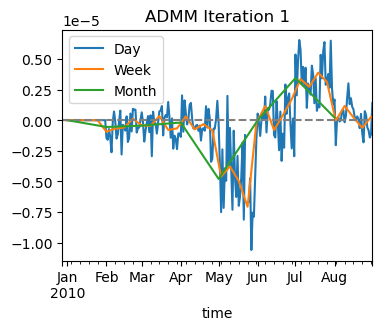

In [18]:
global_avg_plot(w_ser=gosat_df['w_admm0'], title_str=r'ADMM Iteration 1', figsize=(4, 3))

#### Heat maps

In [19]:
# define a color scheme
norm_start = mcolors.Normalize(
    vmin=gosat_df['w_start'].min(),
    vmax=gosat_df['w_start'].max(),
)
norm = mcolors.Normalize(
    vmin=gosat_df[['w_start', 'w_admm0']].values.flatten().min(),
    vmax=gosat_df[['w_start', 'w_admm0']].values.flatten().max(),
)

In [24]:
# product maps
for i in range(1):
    SAVE_FP = SAVE_FIG_BASE + '/w_y_prods%s.png' % str(i).zfill(2)
    month_map_plot(
        df=gosat_df, w_col_str=f'w_y_prods{i}', norm=None, vmin=-0.0004, vmax=0.0004,
        save_fp=SAVE_FP
    )

In [25]:
# heat map of start
SAVE_FP = SAVE_FIG_BASE + '/w_start.png'
month_map_plot(
    df=gosat_df, w_col_str='w_start', norm=None, vmin=-0.001, vmax=0.001,
    save_fp=SAVE_FP
)

In [27]:
# after current ADMM iterations
for i in range(1):
    SAVE_FP = SAVE_FIG_BASE + '/w_admm%s.png' % str(i).zfill(2)
    month_map_plot(
        df=gosat_df, w_col_str=f'w_admm{i}', norm=None, vmin=-0.0001, vmax=0.0001,
        save_fp=SAVE_FP
    )

# Starting points

#### Saving the points from LEP 08

In [30]:
# read in the optimized output
with open(BASE_DIR + '/08/final_results.pkl', 'rb') as f:
    final_res_08 = pickle.load(f)

In [37]:
# save the new points to a new iteration 10
SAVE_BASE_SP = './data/carbon_flux/results/10/intermediate_starts'
with open(SAVE_BASE_SP + '/w_start_from_lep08.npy', 'wb') as f:
    np.save(file=f, arr=final_res_08['w_opt_output']['vectors'][-1])
    
# saving c starting position
with open(SAVE_BASE_SP + '/c_start_lep08.npy', 'wb') as f:
    np.save(file=f, arr=final_res_08['c_opt_output']['vectors'][-1])
    
# saving lambda starting position
with open(SAVE_BASE_SP + '/lambda_start_lep08.npy', 'wb') as f:
    np.save(file=f, arr=final_res_08['lambda_opt_output']['vectors'][-1])